# Setup 
* !pip install pytorch-lightning neptune-client --quiet

In [1]:
import torch
import pytorch_lightning as pl

print(f"PyTorch version: {torch.__version__}")
print(f"Pytorch Lightning version: {pl.__version__}")

PyTorch version: 1.8.2+cu111
Pytorch Lightning version: 1.5.6


In [2]:
import os
import glob
# import imageio
import random
import subprocess
import numpy as np
import pandas as pd
import nibabel as nib
from argparse import Namespace
import matplotlib.pyplot as plt

from datasetmri import DatasetMRI 
from mriCCDataModule import MRICCDataModule # Transformadas (Data Augmentation) e # Datamodule

from dice_score import dice_coeff # Implementação do Dice



In [3]:
#path_Data = "/content/drive/MyDrive/Unicamp-Mestrado/MRI_Data/MRI_npz/"
path_Data = "../.."
DATASET_NAME = "Brain_projeto_IA901A_2D"

In [4]:
 # DEBUG
 # Tentar carregar todos os exemplos dos dois datasets
from tqdm import tqdm
for mode in ["train", "val"]:
    for sample in tqdm(DatasetMRI(mode, os.path.join(path_Data, DATASET_NAME), mid_slices_only=True), leave=True, position=0, desc="Load testing..."):
        pass

train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: None. dataset fatias do meio: True


Load testing...: 100%|██████████| 256/256 [00:00<00:00, 364.50it/s]


val DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: None. dataset fatias do meio: True


Load testing...: 100%|██████████| 256/256 [00:00<00:00, 376.00it/s]


train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: None. dataset fatias do meio: True


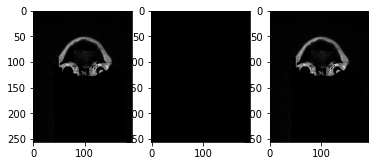

torch.Size([1, 256, 192])


In [5]:
# DEBUG DATASET 
sample = random.choice(DatasetMRI(random.choice(["train"]), os.path.join(path_Data, DATASET_NAME), mid_slices_only=True))
image, seg = sample["image"], sample["seg_image"]
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(seg.squeeze().numpy(), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow((seg.squeeze().numpy()+image.squeeze().numpy())/2, cmap="gray")
plt.show()
#print(image)
print(image.shape)

# Hiperparâmetros

In [6]:
hyperparameters = {"experiment_name": "exp_patch32_init64_manual_RC(enc2)", 
                   "data_folder": os.path.join(path_Data, DATASET_NAME),
                   "mid_slices_only": True,
                   "train_transform_str": "RandomCrop", #RandomCrop
                   "eval_transform_str": None,
                   "patch_size" : (128,56),
                   "max_epochs": 500, 
                   "batch_size_train": 32,
                   "batch_size_val": 1,
                   "nworkers": 8,
                   "snout": 1, # número de canais de saídas da rede de segmentação
                   "nin": 1, # número de canais de entrada
                   "lr": 1e-4, 
                   "manual_seed": 4321,
                   "description": "Experiments for CC segmentation.",
                   "cpu": False,
                  }
hparams = Namespace(**hyperparameters)

for k, v in vars(hparams).items():
    print(f"{k}: {v}")

experiment_name: exp_patch32_init64_manual_RC(enc2)
data_folder: ../../Brain_projeto_IA901A_2D
mid_slices_only: True
train_transform_str: RandomCrop
eval_transform_str: None
patch_size: (128, 56)
max_epochs: 500
batch_size_train: 32
batch_size_val: 1
nworkers: 8
snout: 1
nin: 1
lr: 0.0001
manual_seed: 4321
description: Experiments for CC segmentation.
cpu: False


train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: SegmentationTransform: Compose(
    ToPILImage()
    RandomCrop(size=(128, 56), padding=None)
    ToTensor()
)/Compose(
    ToPILImage()
    RandomCrop(size=(128, 56), padding=None)
    ToTensor()
). dataset fatias do meio: True
val DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: SegmentationTransform: None/None. dataset fatias do meio: True
before torch.Size([32, 1, 128, 56]) torch.Size([32, 1, 128, 56])
after torch.Size([3, 522, 466]) torch.Size([3, 522, 466])


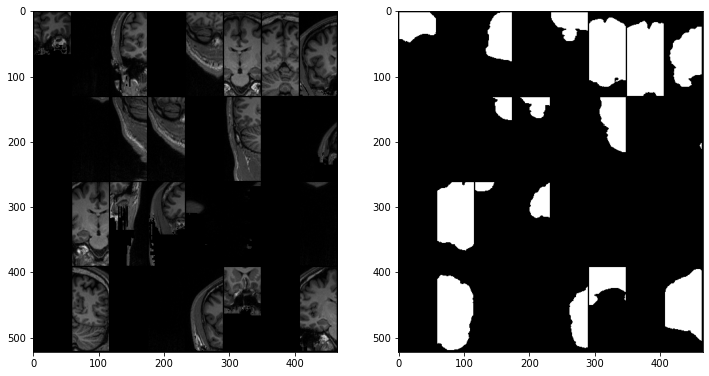

In [7]:
# DEBUG DATA MODULE
from torchvision.utils import make_grid
data_module = MRICCDataModule(Namespace(**hyperparameters))
data_module.setup()

dataloader = data_module.train_dataloader()
sample = next(iter(dataloader))

img_batch = sample["image"]
seg_batch = sample["seg_image"]
print('before', img_batch.shape, seg_batch.shape)
#if hyperparameters["train_transform_str"] == "FiveCrop":
#    bs, ncrops, c, h, w = img_batch.size()
#    img_batch = img_batch.view(-1, c, h, w)
#    seg_batch = seg_batch.view(-1, c, h, w)

img_grid = make_grid(img_batch, normalize=True)
seg_grid = make_grid(seg_batch, normalize=True)
print('after', img_grid.shape, seg_grid.shape)
if hyperparameters["data_folder"] == f"../../{DATASET_NAME}":
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(img_grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(seg_grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.show()

# Treino
Agora vamos usar o Trainer do PL.

* Checkpoint: Salvar o LightningModule, para permitir re-uso sem treinar do zero.

* Logger: Interface com Neptune.

In [8]:
# Passe sua API KEY do Neptune
#from getpass import getpass
# api_key = getpass()

#api_key = os.getenv("NEPTUNE_API_TOKEN")
#api_key = ""
#assert api_key is not None

In [9]:
debug = True
from unet_module2D import LightningMRICCv2 # Lightning Module
#from lightningMRICC import LightningMRICC # Lightning Module (qualificação)
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
# Inicialização do LightningModule
model = LightningMRICCv2(hparams)
#model = LightningMRICC(hparams) # qualificação
data = MRICCDataModule(hparams)

# Onde salvar checkpoints
ckpt_path = "../logs2d/"
os.makedirs(ckpt_path, exist_ok=True)  

# Recomenda-se não inicializar o logger se estiver fazendo debug
if debug:
    neptune_logger = None
    checkpoint_callback = None
else:
    neptune_logger = NeptuneLogger(
        api_key=api_key,
        name=hyperparameters["experiment_name"],
        project="jrodrigues/dissegcc",
    )

    # Configuração do Checkpoint
    checkpoint_callback = [ModelCheckpoint(dirpath=ckpt_path,  # path onde será salvo o checkpoint
                                           filename=hyperparameters["experiment_name"] + "{epoch}-{val_loss:.2f}",
                                           monitor="val_loss",  
                                           mode="min")#, TQDMProgressBar(refresh_rate=50)#,
                            #EarlyStopping(monitor="val_loss",
                            #              mode="min",
                            #              patience = 25, verbose=True)
                            ]
                          
    # Importante prestar atenção nas opções do ModelCheckpoint para não acabar dando overwrite em pesos antigos sem querer!
    #

trainer = pl.Trainer(max_epochs=hyperparameters["max_epochs"],
                     gpus=1,
                     fast_dev_run=debug,
                     logger=neptune_logger,  
                     callbacks=checkpoint_callback
                     )

print("Hyperparameters:\n")
for k, v in hyperparameters.items():
    print(f'{k}: {v}')

trainer.fit(model, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


UNet in channels: 1 batch_norm: True dim: 2d out_channels 1 
Hyperparameters:

experiment_name: exp_patch32_init64_manual_RC(enc2)
data_folder: ../../Brain_projeto_IA901A_2D
mid_slices_only: True
train_transform_str: RandomCrop
eval_transform_str: None
patch_size: (128, 56)
max_epochs: 500
batch_size_train: 32
batch_size_val: 1
nworkers: 8
snout: 1
nin: 1
lr: 0.0001
manual_seed: 4321
description: Experiments for CC segmentation.
cpu: False
train DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: SegmentationTransform: Compose(
    ToPILImage()
    RandomCrop(size=(128, 56), padding=None)
    ToTensor()
)/Compose(
    ToPILImage()
    RandomCrop(size=(128, 56), padding=None)
    ToTensor()
). dataset fatias do meio: True
val DatasetMRI. Localização das Imagens: ../../Brain_projeto_IA901A_2D. Transforms: SegmentationTransform: None/None. dataset fatias do meio: True



  | Name  | Type | Params
-------------------------------
0 | model | UNet | 14.4 M
-------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.578    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it, loss=0.779, val_loss=1.000, val_dice=2.03e-11]
